In [1]:
import os

In [2]:
from tensorflow.keras.applications import inception_v3

from tensorflow.keras.applications.inception_v3 import preprocess_input

from tensorflow.keras.preprocessing import image

from tensorflow.keras.models import Model

In [3]:
from annoy import AnnoyIndex

from tqdm import tqdm

In [4]:
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

In [5]:
inception_model = inception_v3.InceptionV3(weights='imagenet', include_top=True)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [6]:
# inception_model.summary()

In [7]:
fc2_model = Model(inputs=inception_model.input, outputs=inception_model.get_layer("avg_pool").output)

In [8]:
def extract_feats(img_path):
    img = image.load_img(img_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    fc2_feat = fc2_model.predict(x)
    return fc2_feat

In [9]:
images_dir = "./images2"
id2image = {idx: img_name for idx, img_name in enumerate(os.listdir(images_dir))}
image2id = {v:k for k,v in id2image.items()}
print(id2image)
print(image2id)

{0: 'airplane10.tif', 1: 'airplane11.tif', 2: 'airplane12.tif', 3: 'airplane13.tif', 4: 'airplane14.tif', 5: 'airplane15.tif', 6: 'airplane16.tif', 7: 'airplane17.tif', 8: 'airplane18.tif', 9: 'airplane19.tif', 10: 'forest18.tif', 11: 'forest19.tif', 12: 'forest20.tif', 13: 'forest21.tif', 14: 'forest22.tif', 15: 'forest35.tif', 16: 'forest36.tif', 17: 'forest37.tif', 18: 'forest38.tif', 19: 'forest39.tif', 20: 'parkinglot09.tif', 21: 'parkinglot10.tif', 22: 'parkinglot11.tif', 23: 'parkinglot12.tif', 24: 'parkinglot13.tif', 25: 'parkinglot14.tif', 26: 'parkinglot15.tif', 27: 'parkinglot16.tif', 28: 'parkinglot17.tif', 29: 'parkinglot18.tif'}
{'airplane10.tif': 0, 'airplane11.tif': 1, 'airplane12.tif': 2, 'airplane13.tif': 3, 'airplane14.tif': 4, 'airplane15.tif': 5, 'airplane16.tif': 6, 'airplane17.tif': 7, 'airplane18.tif': 8, 'airplane19.tif': 9, 'forest18.tif': 10, 'forest19.tif': 11, 'forest20.tif': 12, 'forest21.tif': 13, 'forest22.tif': 14, 'forest35.tif': 15, 'forest36.tif': 16

In [10]:
image2feat = {}

for _img_name in tqdm(os.listdir(images_dir)):
    image2feat[image2id[_img_name]] = np.squeeze(extract_feats(os.path.join(images_dir, _img_name))).tolist()

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:03<00:00,  7.52it/s]


In [11]:
f = 2048 #维度
t = AnnoyIndex(f)  # Length of item vector that will be indexed

for k, v in tqdm(image2feat.items()):
    t.add_item(k, v)
    
t.build(1000) # 10 trees, More trees give higher precision when querying.
t.save('images_sat_small.ann') 

c:\miniconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The default argument for metric will be removed in future version of Annoy. Please pass metric='angular' explicitly.
  
100%|███████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 29995.02it/s]


True

In [12]:
id2image

{0: 'airplane10.tif',
 1: 'airplane11.tif',
 2: 'airplane12.tif',
 3: 'airplane13.tif',
 4: 'airplane14.tif',
 5: 'airplane15.tif',
 6: 'airplane16.tif',
 7: 'airplane17.tif',
 8: 'airplane18.tif',
 9: 'airplane19.tif',
 10: 'forest18.tif',
 11: 'forest19.tif',
 12: 'forest20.tif',
 13: 'forest21.tif',
 14: 'forest22.tif',
 15: 'forest35.tif',
 16: 'forest36.tif',
 17: 'forest37.tif',
 18: 'forest38.tif',
 19: 'forest39.tif',
 20: 'parkinglot09.tif',
 21: 'parkinglot10.tif',
 22: 'parkinglot11.tif',
 23: 'parkinglot12.tif',
 24: 'parkinglot13.tif',
 25: 'parkinglot14.tif',
 26: 'parkinglot15.tif',
 27: 'parkinglot16.tif',
 28: 'parkinglot17.tif',
 29: 'parkinglot18.tif'}

In [13]:
from ipywidgets import interact
import ipywidgets as widgets

In [14]:
def get_top_k(image_name):
    image_id = image2id[image_name]
    top_k_ids = t.get_nns_by_item(image_id, 5)
    return [id2image[_id] for _id in top_k_ids]

In [15]:
interact(get_top_k, image_name=[_name for _name in image2id.keys()])

interactive(children=(Dropdown(description='image_name', options=('airplane10.tif', 'airplane11.tif', 'airplan…

<function __main__.get_top_k(image_name)>

In [16]:
image_name_list = [_name for _name in image2id.keys()]
top_k_slider = widgets.IntSlider(min=1, max=len(image2id.keys()), value=5)

@interact
def get_top_k2(image_name=image_name_list, Top_k=top_k_slider):
    image_id = image2id[image_name]
    top_k_ids = t.get_nns_by_item(image_id, Top_k)
    return [id2image[_id] for _id in top_k_ids]

interactive(children=(Dropdown(description='image_name', options=('airplane10.tif', 'airplane11.tif', 'airplan…

In [17]:
image_name_list = [_name for _name in image2id.keys()]
top_k_slider = widgets.IntSlider(min=1, max=len(image2id.keys()), value=5)

@interact
def get_top_k3(image_name=image_name_list):
    Top_k=5
    image_id = image2id[image_name]
    top_k_ids = t.get_nns_by_item(image_id, Top_k)
    res_images = [id2image[_id] for _id in top_k_ids]
    plt.figure(figsize=(12, 6))
    plt.subplot(231)
    img = image.load_img(os.path.join(images_dir, image_name), target_size=(299, 299))
    img = image.img_to_array(img)
    plt.imshow(img.astype('uint8'))
    plt.axis('off')
    plt.title("搜索图片")
    
    for idx, _img_name in enumerate((res_images)):
        plt.subplot(f"23{idx+2}")
        img = image.load_img(os.path.join(images_dir, _img_name), target_size=(299, 299))
        img = image.img_to_array(img)
        plt.imshow(img.astype('uint8'))
        plt.axis('off')
        plt.title(f"结果图片 {idx+1}")

interactive(children=(Dropdown(description='image_name', options=('airplane10.tif', 'airplane11.tif', 'airplan…

In [18]:
img = image.load_img(os.path.join(images_dir, image_name_list[0]), target_size=(299, 299))
img = image.img_to_array(img)

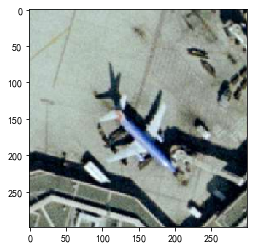

In [19]:
plt.imshow(img.astype('uint8'))

In [20]:
upload_image_dir = "./upload_image_dir/"

upload_image_name_list = [_name for _name in os.listdir(upload_image_dir)]
top_k_slider = widgets.IntSlider(min=1, max=len(image2id.keys()), value=5)

@interact
def get_top_k3(image_name=upload_image_name_list):
    Top_k=5
    # os.path.join(upload_image_dir, image_name)
    upload_img_feat = extract_feats(upload_image_dir + image_name).tolist()[0]
    # top_k_ids = t.get_nns_by_item(image_id, Top_k)
    top_k_ids = t.get_nns_by_vector(upload_img_feat, Top_k)
    res_images = [id2image[_id] for _id in top_k_ids]
    plt.figure(figsize=(12, 6))
    plt.subplot(231)
    img = image.load_img(os.path.join(upload_image_dir, image_name), target_size=(299, 299))
    img = image.img_to_array(img)
    plt.imshow(img.astype('uint8'))
    plt.axis('off')
    plt.title("搜索图片")
    
    for idx, _img_name in enumerate((res_images)):
        plt.subplot(f"23{idx+2}")
        img = image.load_img(os.path.join(images_dir, _img_name), target_size=(299, 299))
        img = image.img_to_array(img)
        plt.imshow(img.astype('uint8'))
        plt.axis('off')
        plt.title(f"结果图片 {_img_name}")

interactive(children=(Dropdown(description='image_name', options=('airplane89.tif', 'airplane90.tif', 'airplan…

In [21]:
def get_top_k_test(image_name=upload_image_name_list):
    Top_k=5
    # os.path.join(upload_image_dir, image_name)
    upload_img_feat = extract_feats(upload_image_dir + image_name).tolist()[0]
    # top_k_ids = t.get_nns_by_item(image_id, Top_k)
    top_k_ids = t.get_nns_by_vector(upload_img_feat, Top_k)
    res_images = [id2image[_id] for _id in top_k_ids]
    return res_images
#     plt.figure(figsize=(12, 6))
#     plt.subplot(231)
#     img = image.load_img(os.path.join(upload_image_dir, image_name), target_size=(299, 299))
#     img = image.img_to_array(img)
#     plt.imshow(img.astype('uint8'))
#     plt.axis('off')
#     plt.title("搜索图片")
    
#     for idx, _img_name in enumerate((res_images)):
#         plt.subplot(f"23{idx+2}")
#         img = image.load_img(os.path.join(images_dir, _img_name), target_size=(299, 299))
#         img = image.img_to_array(img)
#         plt.imshow(img.astype('uint8'))
#         plt.axis('off')
#         plt.title(f"结果图片 {_img_name}")

In [22]:
%%timeit

get_top_k_test("face2.jpg")

27.5 ms ± 739 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [23]:
get_top_k_test("face2.jpg")

['parkinglot10.tif',
 'parkinglot11.tif',
 'airplane17.tif',
 'parkinglot12.tif',
 'parkinglot18.tif']